In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img

%matplotlib inline

2023-11-15 16:21:26.313254: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Tensorflow is a framework for deep learning and Keras is a library which provides high-level abstraction which simplifies neural network generation.

In [2]:
path = './clothing-dataset-small/train/t-shirt'
name = 'ff8ca4c9-b3dc-4d84-8dba-095581f94dbe.jpg'
fullname = f'{path}/{name}'

img = load_img(fullname, target_size=(299, 299))

print(img)

<PIL.Image.Image image mode=RGB size=299x299 at 0x7FD59C0F9640>


In [3]:
R, G, B = np.array(img)[0][0]

np.array(img).shape

(299, 299, 3)

### Using a pre-trained convolutional neural network

- Imagenet dataset: https://www.image-net.org/
- Pre-trained models: https://keras.io/api/applications/

In [4]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [5]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

2023-11-15 16:21:32.440896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-15 16:21:32.447030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-15 16:21:32.447617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-15 16:21:32.448558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [6]:
x = np.array(img)

X = np.array([x])

X = preprocess_input(X)

In [7]:
pred = model.predict(X)

decode_predictions(pred)

2023-11-15 16:21:36.215515: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-11-15 16:21:36.856797: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-15 16:21:36.857651: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-15 16:21:36.857693: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-11-15 16:21:36.858664: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-15 16:21:36.858756: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 3s 3s/step


[[('n03595614', 'jersey', 0.96263796),
  ('n03710637', 'maillot', 0.004248076),
  ('n04370456', 'sweatshirt', 0.0018063366),
  ('n04456115', 'torch', 0.0009411157),
  ('n04532106', 'vestment', 0.0007188157)]]

ImageNet is not particularly helpful for our purpose. This means that we need to train a more particular model with our own list of classes. By building on top of the work of large universities and organisations, we don't have to generate an image classification model from scratch.

### Convolutional Neural Networks

### Transfer Learning

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [10]:
train_ds = train_gen.flow_from_directory('./clothing-dataset-small/train', target_size=(150, 150), batch_size=32)

Found 3068 images belonging to 10 classes.


In [11]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [12]:
X, y = next(train_ds)

In [13]:
X.shape, y.shape

((32, 150, 150, 3), (32, 10))

In [14]:
y[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

The `y` vector categorises the input images into classes similarly to OneHot encoding.

In [15]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150), 
    batch_size=32, 
    shuffle=False
)

Found 341 images belonging to 10 classes.


In [16]:
val_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

Let us train our custom model (dense layers) on top of the convolutional layers of ImageNet.

Keras Terminology:

- **Top**: Dense Layers + Predictions
- **Bottom**: Convultional Layers + Vector Representation

We are only interested in the **bottom** of ImageNet.

In [17]:
# Specifying that we want the bottom of ImageNet as our base model
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

# Don't want to retrain the base model (want to keep bottom)
base_model.trainable = False

# Specifying model inputs
inputs = keras.Input(shape=(150, 150, 3))

# Establishing base
base = base_model(inputs)

# Pooling
vectors = keras.layers.GlobalAveragePooling2D()(base)

# Output
outputs = keras.layers.Dense(10)(vectors)

# Final model 
model = keras.Model(inputs, outputs)

# Model predictions
preds = model.predict(X)

1/1 [==============================] - 1s 1s/step


Require an **optimiser** to tune the weights for optimal performance. See optimisation theory here: https://cs231n.github.io/optimization-1/

To gauge optimisation we minimise some loss function using our optimiser of choice. There are several loss functions; the following are examples of loss functions and their use cases:
1. **Categorical Cross Entropy** - Multi-class Classification
2. **Binary Cross Entropy** - Binary Classification
3. **Mean Squared Error** - Regression

<hr>

**Logits** describes the row output of a dense layer before applying softmax.

$$\sigma(\vec{z})_{i} = \frac{e^{z_{i}}}{\sum_{j=1}^{K}e^{z_{j}}}$$

\begin{align}
    \sigma &= \text{softmax} \\
    \vec{z} &= \text{input vector} \\
    e^{z_{i}} &= \text{standard exponetial function for input vector} \\
    e^{z_{j}} &= \text{standard exponetial function for output vector} \\
    K &= \text{number of classes in multi-class classifier}
\end{align}

<hr>

`metrics` in `model.compile` outputs a metric of choice for each training step.

In [18]:
learning_rate = 0.01

# Optimiser function
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Loss function to minimise
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

# Compiling the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 18s 166ms/step - loss: 1.3372 - accuracy: 0.6571 - val_loss: 0.7787 - val_accuracy: 0.7977
Epoch 2/10
96/96 [==============================] - 12s 123ms/step - loss: 0.5781 - accuracy: 0.8129 - val_loss: 0.9145 - val_accuracy: 0.7742
Epoch 3/10
96/96 [==============================] - 12s 123ms/step - loss: 0.4116 - accuracy: 0.8693 - val_loss: 0.8018 - val_accuracy: 0.8094
Epoch 4/10
96/96 [==============================] - 12s 123ms/step - loss: 0.2486 - accuracy: 0.9110 - val_loss: 1.0402 - val_accuracy: 0.7419
Epoch 5/10
96/96 [==============================] - 12s 122ms/step - loss: 0.1555 - accuracy: 0.9423 - val_loss: 0.8739 - val_accuracy: 0.8065
Epoch 6/10
96/96 [==============================] - 12s 122ms/step - loss: 0.1215 - accuracy: 0.9576 - val_loss: 0.8960 - val_accuracy: 0.8006
Epoch 7/10
96/96 [==============================] - 12s 122ms/step - loss: 0.0764 - accuracy: 0.9746 - val_loss: 0.9024 - val_accuracy: 0.8065

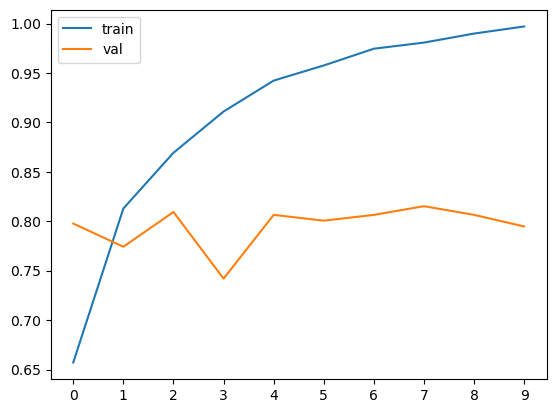

In [19]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')

plt.xticks(np.arange(10))

plt.legend()

### Adjusting the learning rate

Learning Rate ~ How fast you can read

The faster you read books, the less information you're absorbing; whereas, the slower you read books, the more information you absorb but progress is slower.

- Learning rate too high -- Overfitting
- Learning rate too low -- Underfitting

In [20]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [21]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10
96/96 [==============================] - 14s 129ms/step - loss: 1.8904 - accuracy: 0.3768 - val_loss: 1.5822 - val_accuracy: 0.5191
Epoch 2/10
96/96 [==============================] - 12s 122ms/step - loss: 1.3788 - accuracy: 0.5541 - val_loss: 1.2466 - val_accuracy: 0.5924
Epoch 3/10
96/96 [==============================] - 12s 122ms/step - loss: 1.1372 - accuracy: 0.6359 - val_loss: 1.0649 - val_accuracy: 0.6686
Epoch 4/10
96/96 [==============================] - 12s 123ms/step - loss: 0.9965 - accuracy: 0.6845 - val_loss: 0.9504 - val_accuracy: 0.7155
Epoch 5/10
96/96 [==============================] - 12s 121ms/step - loss: 0.9023 - accuracy: 0.7135 - val_loss: 0.8814 - val_accuracy: 0.7361
Epoch 6/10
96/96 [==============================] - 12s 122ms/step - loss: 0.8347 - accuracy: 0.7291 - val_loss: 0.8227 - val_accuracy: 0.7537
Epoch 7/10
96/96 [==============================] - 12s 122ms/step - loss: 0.7822 - accuracy: 0.7448 - val_loss: 0.7884 - val_accuracy:

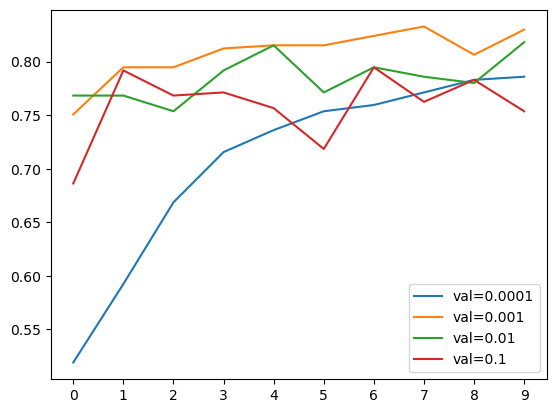

In [22]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [23]:
learning_rate = 0.001

### Checkpointing

Sometimes, we want to save a model prior to the final epoch. We can do this using **checkpointing**.

After evaluating an epoch we can use **callbacks**. There are several types of callbacks; `ModelCheckpoint()` is the callback we're interested in.

We only want to save the epoch with the best accuracy; therefore, `save_best_only=True` and `monitor='val_accuracy'`.

In [24]:
model.save_weights('model_v1.h5', save_format='h5')

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [26]:
model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/10
96/96 [==============================] - 15s 135ms/step - loss: 1.1258 - accuracy: 0.6239 - val_loss: 0.7105 - val_accuracy: 0.7683
Epoch 2/10
96/96 [==============================] - 12s 127ms/step - loss: 0.6408 - accuracy: 0.7810 - val_loss: 0.6192 - val_accuracy: 0.8065
Epoch 3/10
96/96 [==============================] - 12s 125ms/step - loss: 0.5158 - accuracy: 0.8315 - val_loss: 0.5745 - val_accuracy: 0.8152
Epoch 4/10
96/96 [==============================] - 12s 125ms/step - loss: 0.4346 - accuracy: 0.8625 - val_loss: 0.5535 - val_accuracy: 0.8270
Epoch 5/10
96/96 [==============================] - 12s 123ms/step - loss: 0.3762 - accuracy: 0.8853 - val_loss: 0.5554 - val_accuracy: 0.8123
Epoch 6/10
96/96 [==============================] - 12s 123ms/step - loss: 0.3317 - accuracy: 0.9042 - val_loss: 0.5574 - val_accuracy: 0.8123
Epoch 7/10
96/96 [==============================] - 12s 125ms/step - loss: 0.2998 - accuracy: 0.9123 - val_loss: 0.5262 - val_accuracy: 0.8416

Examining our file repository, notice that there are now several files titled *xception_v1_(ver)_(acc)*. These files are checkpoints of the highest scoring models. Files were not generated for each epoch which suggests that the model becomes worse with too much training (result of overfitting to training data).

### Adding additional dense layers to neural network

So far: 
- Take **bottom** from pre-trained ImageNet model, Xception
- Use convolutional layers to extract vector representation of input images
- Introduce dense layer which produces an output based on vector input 

We can introduce additional dense layers to make the neural network more powerful.

`activation` describes the transformation from row scores to $x$ (in our case, $x$ = *probabilities*).

Examples of activation functions:
- Sigmoid & Softmax (Output)
- ReLU, etc. (Intermediate)

In [29]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(10)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [30]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

10
Epoch 1/10
96/96 [==============================] - 15s 129ms/step - loss: 1.3940 - accuracy: 0.5300 - val_loss: 0.9282 - val_accuracy: 0.7273
Epoch 2/10
96/96 [==============================] - 12s 122ms/step - loss: 0.7751 - accuracy: 0.7526 - val_loss: 0.7203 - val_accuracy: 0.7771
Epoch 3/10
96/96 [==============================] - 12s 121ms/step - loss: 0.5831 - accuracy: 0.8110 - val_loss: 0.6245 - val_accuracy: 0.8006
Epoch 4/10
96/96 [==============================] - 12s 120ms/step - loss: 0.4721 - accuracy: 0.8481 - val_loss: 0.5907 - val_accuracy: 0.8094
Epoch 5/10
96/96 [==============================] - 12s 120ms/step - loss: 0.3994 - accuracy: 0.8742 - val_loss: 0.5624 - val_accuracy: 0.8065
Epoch 6/10
96/96 [==============================] - 12s 121ms/step - loss: 0.3459 - accuracy: 0.8931 - val_loss: 0.5571 - val_accuracy: 0.8123
Epoch 7/10
96/96 [==============================] - 12s 120ms/step - loss: 0.2926 - accuracy: 0.9153 - val_loss: 0.5532 - val_accuracy: 0.8

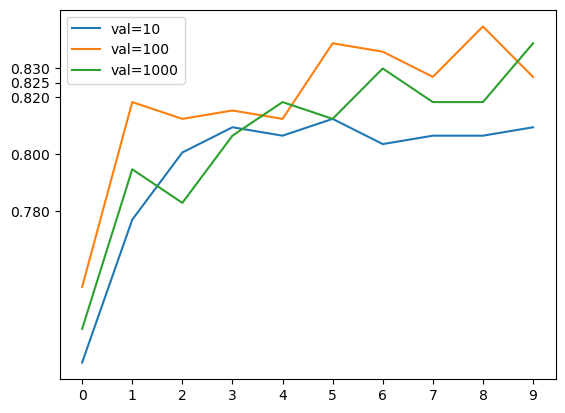

In [31]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()

### Regularisation and dropout

Direct focus of neural network to general trends as opposed to minute details.

To do this, we can use **dropout** to randomly hide part of the input image.

Dropout does this by taking a dense layer and freezing part of the layer. So, during training, a unique part of the inner layer is frozen. This is effectively ignoring part of an image.

`droprate` is the proportion of the vector representation (input image) we want to ignore.

NOTE: After introducing regularisation, one must scale the number of epochs to account for the active restrictions on model training (partially hiding the input from the model).

In [32]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [33]:
learning_rate = 0.001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/30
96/96 [==============================] - 16s 139ms/step - loss: 0.9653 - accuracy: 0.6714 - val_loss: 0.6487 - val_accuracy: 0.7977
Epoch 2/30
96/96 [==============================] - 12s 124ms/step - loss: 0.5065 - accuracy: 0.8256 - val_loss: 0.6701 - val_accuracy: 0.7771
Epoch 3/30
96/96 [==============================] - 12s 121ms/step - loss: 0.3629 - accuracy: 0.8771 - val_loss: 0.5723 - val_accuracy: 0.8123
Epoch 4/30
96/96 [==============================] - 12s 121ms/step - loss: 0.2484 - accuracy: 0.9228 - val_loss: 0.5388 - val_accuracy: 0.8240
Epoch 5/30
96/96 [==============================] - 12s 122ms/step - loss: 0.1719 - accuracy: 0.9557 - val_loss: 0.5910 - val_accuracy: 0.7918
Epoch 6/30
96/96 [==============================] - 12s 125ms/step - loss: 0.1276 - accuracy: 0.9736 - val_loss: 0.6048 - val_accuracy: 0.8094
Epoch 7/30
96/96 [==============================] - 12s 121ms/step - loss: 0.0818 - accuracy: 0.9863 - val_loss: 0.6270 - val_accuracy: 0.

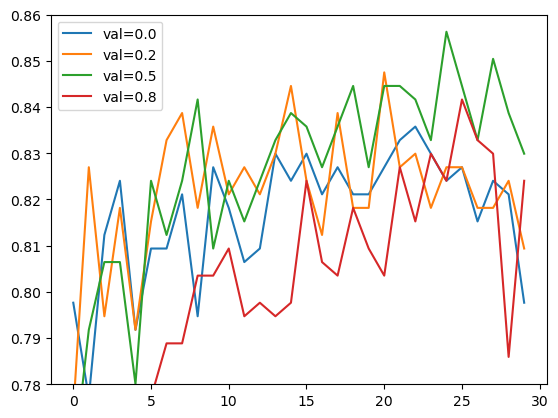

In [34]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.78, 0.86)
plt.legend()

### Data augmentation

Method of creating additional data from manipulating existing data.

(Some) Types of augmentation:
- Crop
- Flip
- Translation
- Rotation
- Zoom
- Contrast
- Brightness

When choosing augmentations:
- Use your own judgement
- Examine the dataset and note what kind of variations there are:
    - If all of the images are centered: Consider rotations and shifts?
- Sensitivity analysis (similar to tuning a hyperparameter)
    - Better performance = use. No difference = investigate more. Worse: don't use
    
    
 $$\left(\textbf{CPU} \rightarrow \text{Generates augmentations}\right) \Longrightarrow \left(\textbf{GPU} \rightarrow \text{Fits the model}\right)$$

### Training larger models

Consider images of size `299x299` instead of `150x150`. Augmentations are more effective when working with larger images as the images are more detailed.

Larger image sizes make training models more time consuming, but improve the accuracy considerably.

### Conclusion

- We can use pre-trained models for general image classification
- Convolutional layers let us turn an image into a vector
- Dense layers use the vector to make the predictions
- Instead of training a model from scratch, we can use transfer learning and re-use already trained convolutional layers
- First, train a small model (150x150) before training a big one (299x299)
- Learning rate - how fast the model trians. Fast learners aren't always best ones
- We can save the best model using callbacks and checkpointing
- To avoid overfitting, use dropout and augmentation